# Real Data Science Example: Gender in Comic Books

Original `fivethirtyeight.com` article: https://fivethirtyeight.com/features/women-in-comic-books/

Public dataset: https://github.com/fivethirtyeight/data/tree/master/comic-characters

#### Details we're sweeping under the rug for now:

In [18]:
from datascience import *
from datascience.predicates import are
import numpy as np
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

def load_and_clean_table(url):
    """Loads a table about Marvel or DC comics from fivethirtyeight's
    GitHub repository, and cleans up a few formatting details."""
    tbl = Table.read_table(url)
    if "Year" in tbl.labels:
        tbl.relabel("Year", "YEAR")
        tbl.update({'PUBLISHER': 'Marvel'})
    else:
        tbl.update({'PUBLISHER': 'DC'})
    tbl.relabel("name", "NAME")
    tbl.update({"APPEARANCES": np.nan_to_num(tbl.column("APPEARANCES"))})
    tbl.update({"GENDER": np.char.replace(tbl.column("SEX"), "nan", "Unknown")})
    tbl.update({"GENDER": np.char.replace(tbl.column("GENDER"), " Characters", "")})
    
    def extract_month(date_text):
        import dateutil.parser
        try:
            return dateutil.parser.parse(date_text).month
        except:
            return "Unknown"
    
    tbl.update({"MONTH": tbl.apply(extract_month, "FIRST APPEARANCE")})
    tbl.update({"MONTH": tbl.apply(lambda d: int(d) if d != "Unknown" else -1, "MONTH")})
    tbl = tbl.select("PUBLISHER", "NAME", "GENDER", "APPEARANCES", "YEAR", "MONTH")
    for l in tbl.labels:
        tbl.relabel(l, l.capitalize())
    tbl = tbl.where(~np.isnan(tbl.column("Year")))
    return tbl

def normalize(data):
    return 100*data / sum(data)

def plot_percentages(full_tbl, x_axis_col, group_col, filter_col, filter_value):
    filtered_tbl = full_tbl.where(filter_col, are.equal_to(filter_value))
    full = full_tbl.pivot(group_col, x_axis_col)
    filtered = filtered_tbl.pivot(group_col, x_axis_col)
    both = filtered.join(x_axis_col, full)
    percentages = both.select(x_axis_col)
    for l in filtered.labels:
        if l != x_axis_col:
            percentages.append_column("% {} ({})".format(filter_value, l), 100*both.column(l)/both.column(l + "_2"))
    percentages.plot(x_axis_col)
    plots.ylim([0, 100])

def round_to_nearest(nums, rounding_amount):
    return np.round(nums / rounding_amount) * rounding_amount

## Load the data

In [19]:
marvel_url = "https://github.com/fivethirtyeight/data/raw/master/comic-characters/marvel-wikia-data.csv"
dc_url = "https://github.com/fivethirtyeight/data/raw/master/comic-characters/dc-wikia-data.csv"

marvel = load_and_clean_table(marvel_url)
dc = load_and_clean_table(dc_url)

## Look at the raw data

In [20]:
marvel

Publisher,Name,Gender,Appearances,Year,Month
Marvel,Spider-Man (Peter Parker),Male,4043,1962,8
Marvel,Captain America (Steven Rogers),Male,3360,1941,3
Marvel,"Wolverine (James \""Logan\"" Howlett)",Male,3061,1974,10
Marvel,"Iron Man (Anthony \""Tony\"" Stark)",Male,2961,1963,3
Marvel,Thor (Thor Odinson),Male,2258,1950,11
Marvel,Benjamin Grimm (Earth-616),Male,2255,1961,11
Marvel,Reed Richards (Earth-616),Male,2072,1961,11
Marvel,Hulk (Robert Bruce Banner),Male,2017,1962,5
Marvel,Scott Summers (Earth-616),Male,1955,1963,9
Marvel,Jonathan Storm (Earth-616),Male,1934,1961,11


In [21]:
dc

Publisher,Name,Gender,Appearances,Year,Month
DC,Batman (Bruce Wayne),Male,3093,1939,5
DC,Superman (Clark Kent),Male,2496,1986,10
DC,Green Lantern (Hal Jordan),Male,1565,1959,10
DC,James Gordon (New Earth),Male,1316,1987,2
DC,Richard Grayson (New Earth),Male,1237,1940,4
DC,Wonder Woman (Diana Prince),Female,1231,1941,12
DC,Aquaman (Arthur Curry),Male,1121,1941,11
DC,Timothy Drake (New Earth),Male,1095,1989,8
DC,Dinah Laurel Lance (New Earth),Female,1075,1969,11
DC,Flash (Barry Allen),Male,1028,1956,10


## Get comfortable with basic numerical facts ("statistics") about the data

In [22]:
print("There were {:d} Marvel characters and {:d} DC characters.".format(
                  marvel.num_rows,           dc.num_rows))

There were 15561 Marvel characters and 6827 DC characters.


In [23]:
all_comics = marvel.copy().append(dc)

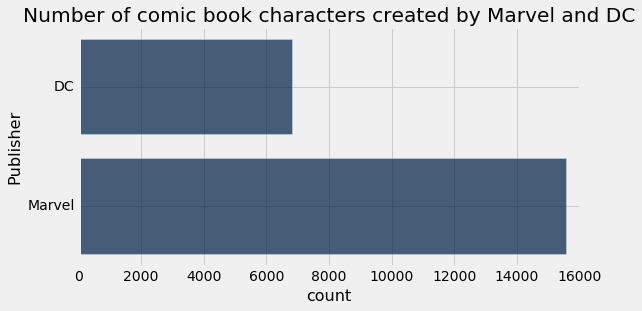

In [24]:
all_comics.group_barh("Publisher", width=8)
plots.title("Number of comic book characters created by Marvel and DC");

### Breakdown by gender

In [25]:
all_comics.group("Gender")

Gender,count
Agender,36
Female,5575
Genderfluid,2
Genderless,20
Male,15835
Transgender,1
Unknown,919


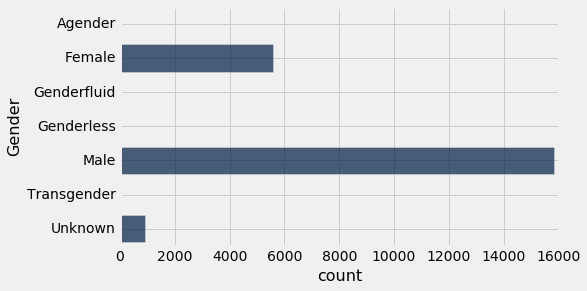

In [26]:
all_comics.group_barh("Gender", width=7)

### Breakdown by publisher and gender

In [27]:
all_comics.pivot("Publisher", "Gender")

Gender,DC,Marvel
Agender,0,36
Female,1947,3628
Genderfluid,0,2
Genderless,20,0
Male,4735,11100
Transgender,1,0
Unknown,124,795


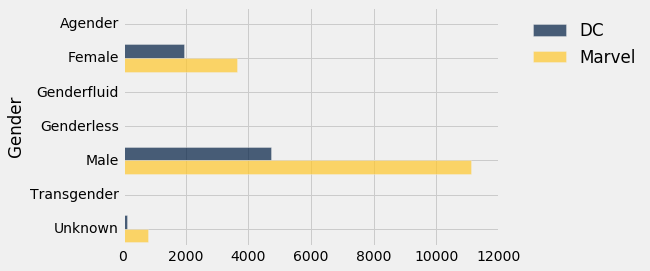

In [28]:
all_comics.pivot("Publisher", "Gender").barh("Gender")

### Normalize for a fair comparison of rates

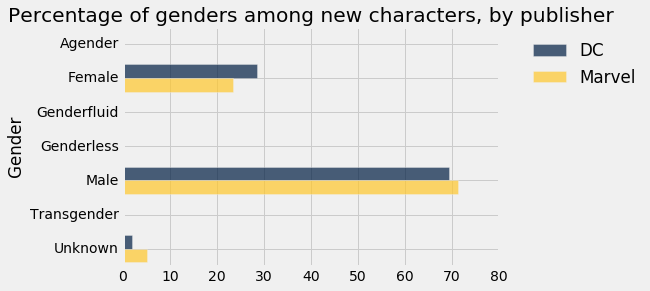

In [29]:
gender_by_publisher = all_comics.pivot("Publisher", "Gender")
dc_percent = normalize(gender_by_publisher.column("DC"))
marvel_percent = normalize(gender_by_publisher.column("Marvel"))
gender_by_publisher.with_column("DC", dc_percent)\
                   .with_column("Marvel", marvel_percent)\
                   .barh("Gender")
plots.title("Percentage of genders among new characters, by publisher");

## How did the gender composition of new characters change over time?

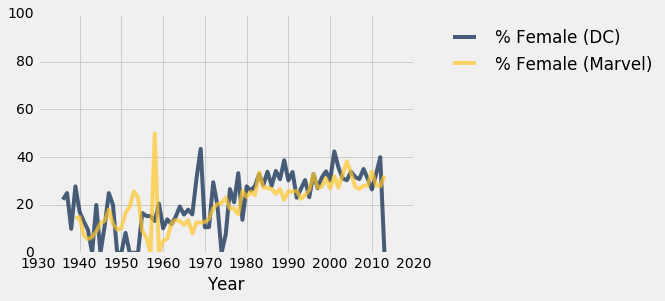

In [30]:
plot_percentages(all_comics, "Year", "Publisher", "Gender", "Female")

### Why is it so noisy?

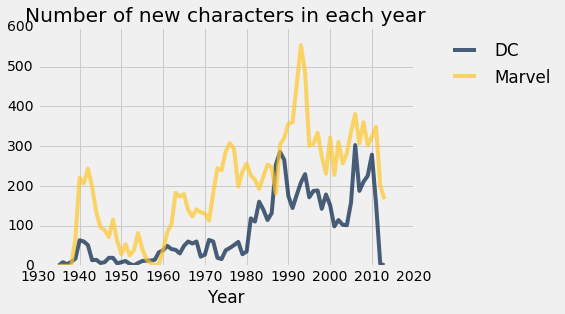

In [31]:
all_comics.pivot("Publisher", "Year").plot("Year")
plots.title("Number of new characters in each year");

### Solution: Plot each 5-year period instead of every year

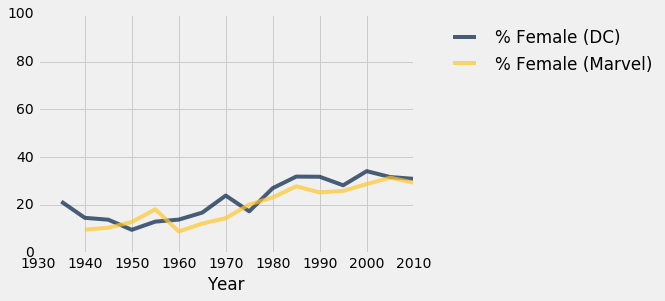

In [32]:
before_2013 = all_comics.where("Year", are.below(2013))
rounded_years = round_to_nearest(before_2013.column("Year"), 5)

plot_percentages(
    before_2013.with_column("Year", rounded_years),
    "Year", "Publisher", "Gender", "Female")